# Importing data and libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
all_xray_df = pd.read_csv('Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('combined_data', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

Scans found: 25591 , Total Headers 112120


In [4]:
#To loop through images files and take only rows for which the images are available
image_present = []

for i in all_image_paths.keys():
    image_present.append(i)


new_df= all_xray_df[all_xray_df['Image Index'].isin(image_present)]

In [5]:
all_xray_df = new_df
all_xray_df.shape

(25591, 12)

In [6]:
# Add the path to the dataset.
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
14151,00003662_009.png,No Finding,9,3662,55,F,PA,2094,2542,0.143,0.143,NaN,combined_data\00003662_009.png
3622,00000980_001.png,No Finding,1,980,40,M,PA,2500,2048,0.171,0.171,NaN,combined_data\00000980_001.png
4474,00001208_005.png,No Finding,5,1208,29,F,PA,2992,2991,0.143,0.143,NaN,combined_data\00001208_005.png


### Removing some of the 'No findings cases' from 14000 images to about 4000 images

In [7]:
first_half = all_xray_df[0:18000]
second_half = all_xray_df[18000:]

all_xray_trial1 = first_half[first_half['Finding Labels']!= 'No Finding']
all_xray_trial2 = second_half
frames = [all_xray_trial1, all_xray_trial2]
all_xray_df = pd.concat(frames)
len(all_xray_df)

15164

In [8]:
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5966,00001609_002.png,Effusion|Pneumothorax,2,1609,39,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27912,00007274_009.png,No Finding,9,7274,32,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26840,00007018_014.png,Cardiomegaly,14,7018,28,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Considering only 'diseases' that have atleast 1000 images in the dataset 

In [9]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (6) [('Atelectasis', 2485), ('Effusion', 2484), ('Infiltration', 3684), ('No Finding', 4414), ('Nodule', 1272), ('Pneumothorax', 1148)]


In [10]:
# Split the lables by '|' and check how many labels are present for each image.
# weight is 0.1 + number of findings

sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(len(sample_weights), weights=sample_weights)

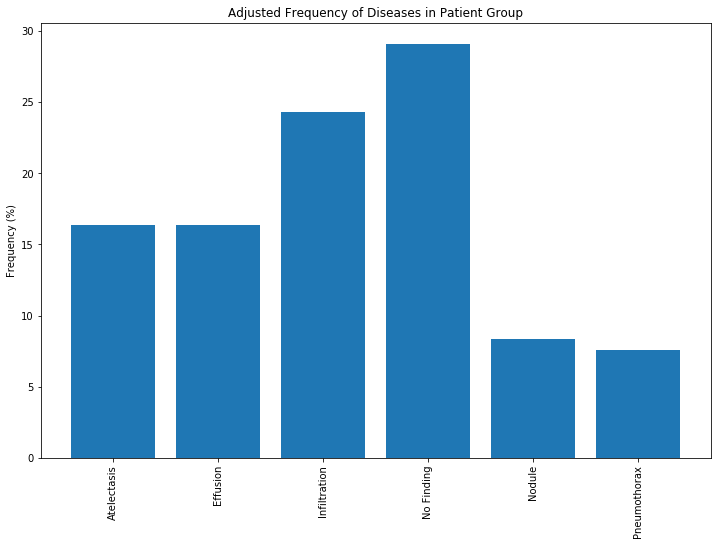

In [11]:
# Adjusted frequency of disease grps

label_counts = 100*np.mean(all_xray_df[all_labels].values,0) # mean number of labels for each image
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

### Prepare Data for Modeling

In [13]:
# Prepare training data
# Create target vector

all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [14]:
# data split

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2019,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 11373 test 3791


### Create Generator

In [15]:
# Loading and transforming images
# ImageDataGenerator: Generate batches of tensor image data with real-time data augmentation. 


from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [16]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [1]:
# IMG_SIZE = (128, 128)
# test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
# train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

# train_gen = datagen.flow_from_dataframe(dataframe=train_df, directory=None, x_col = 'path',
# y_col = 'newLabel', class_mode = 'categorical',
# classes = all_labels, target_size = IMG_SIZE, color_mode = 'grayscale',
# batch_size = 256) 

# test_gen = datagen.flow_from_dataframe(dataframe= test_df, directory=None, x_col = 'path',
# y_col = 'newLabel', class_mode = 'categorical',
# classes = all_labels, target_size = IMG_SIZE, color_mode = 'grayscale',
# batch_size = 256) 

# test_X, test_Y = next(datagen.flow_from_dataframe(dataframe=test_df, 
# directory=None,
# x_col = 'path', y_col = 'newLabel', 
# class_mode = 'categorical', classes = all_labels,
# target_size = IMG_SIZE, color_mode = 'grayscale', batch_size = 512))

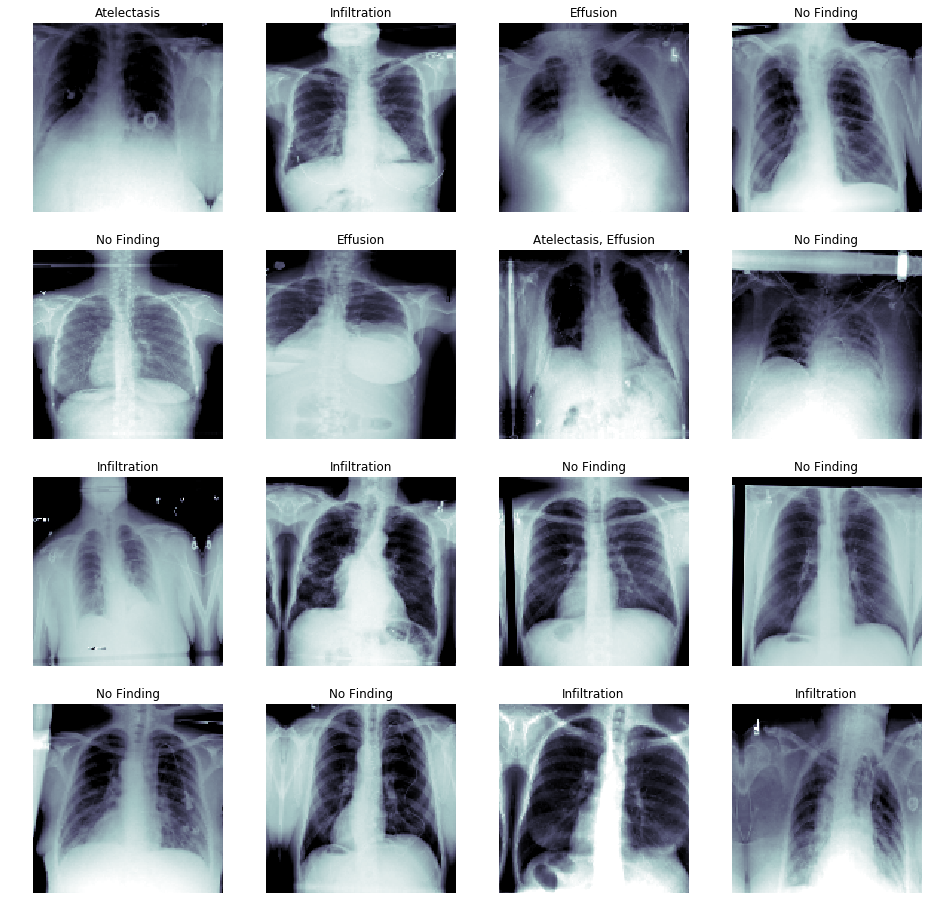

In [24]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [ ]:
from keras.models import load_model
# load model
model = load_model('model_mobnet.h5')
# summarize model.
model.summary()

# evaluate the model
# score = model.evaluate(test_X, test_Y, verbose=1)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

In [26]:
# Evaluation metrics
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
# Creating a model
import keras
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
base_mobilenet_model = MobileNetV2(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)

multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(rate= 0.5))
multi_disease_model.add(Dense(512, kernel_initializer ='uniform'))
multi_disease_model.add(Dropout(rate = 0.5))
multi_disease_model.add(Dense(output_dim = len(all_labels), activation = 'sigmoid', kernel_initializer ='uniform'))
multi_disease_model.compile(optimizer = 'nadam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae',f1_m,'categorical_accuracy', recall_m])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257408   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
Total params: 2,916,358
Trainable params: 2,882,246
Non-trainable params: 34,112
_____________________________________________________________

C:\Users\Priyanka Jindal\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", kernel_initializer="uniform", units=6)`
  from ipykernel import kernelapp as app


In [28]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('xray_mobnetv2')

# Save the model after every epoch.
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience= 4)
callbacks_list = [checkpoint, early]

In [29]:
mobnet_mdl = multi_disease_model.fit_generator(
  train_gen,
  validation_data=(test_X, test_Y),
  epochs= 1,
  steps_per_epoch= 10,
  callbacks = callbacks_list
)

Epoch 1/1
10/10 [==============================] - 630s 63s/step - loss: 0.6811 - binary_accuracy: 0.7389 - mean_absolute_error: 0.3176 - f1_m: 0.1323 - categorical_accuracy: 0.2449 - recall_m: 0.1438 - val_loss: 2.0835 - val_binary_accuracy: 0.7959 - val_mean_absolute_error: 0.2121 - val_f1_m: 0.0000e+00 - val_categorical_accuracy: 0.1875 - val_recall_m: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.08355, saving model to xray_mobnetv2_weights.best.hdf5


In [ ]:
# Save the model
multi_disease_model.save('model_mobnet.h5', overwrite = False)

END OF CODE


In [30]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

512/512 [==============================] - 24s 47ms/step


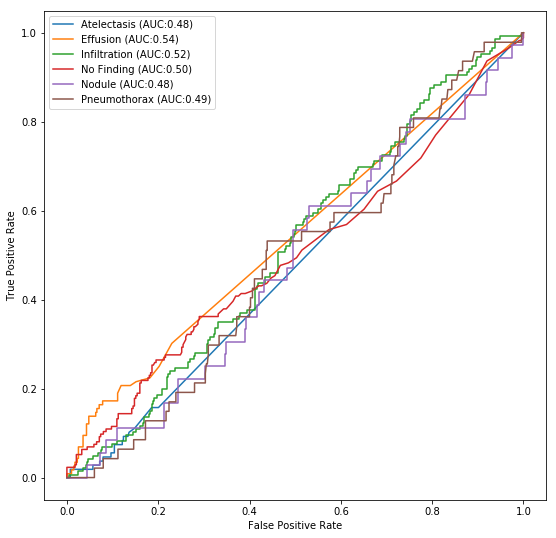

In [31]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [ ]:
# Show images and associated predictions.

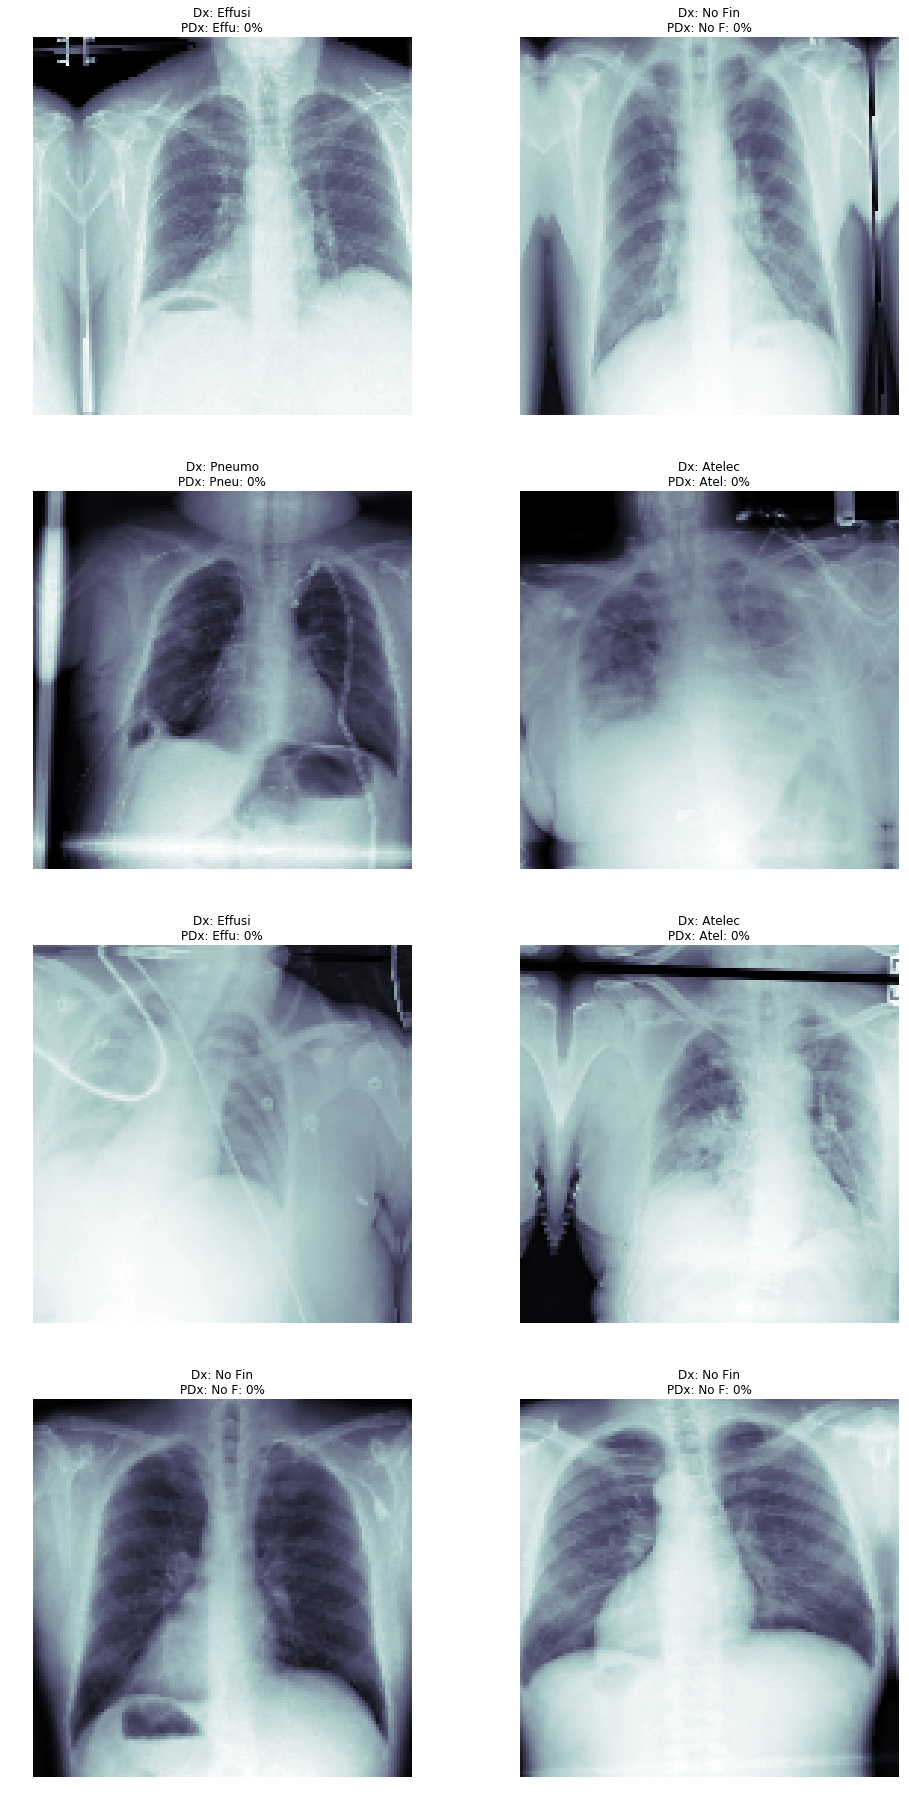

In [32]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

In [33]:
multi_disease_model.evaluate(test_X, test_Y)

512/512 [==============================] - 25s 48ms/step


[2.083988703787327, 0.7958984225988388, 0.21211389172822237, 0.0, 0.1875, 0.0]

In [34]:
from sklearn import metrics
pred_class = np.round(pred_Y,1)
pred_class = np.ceil(pred_class)
classification_metrics = metrics.classification_report(test_Y, pred_class, target_names = all_labels)
print(classification_metrics)

              precision    recall  f1-score   support

 Atelectasis       0.10      0.02      0.03       108
    Effusion       0.39      0.08      0.13       116
Infiltration       0.30      0.51      0.38       146
  No Finding       0.44      0.07      0.12       174
      Nodule       0.00      0.00      0.00        36
Pneumothorax       0.00      0.00      0.00        47

   micro avg       0.29      0.15      0.20       627
   macro avg       0.21      0.11      0.11       627
weighted avg       0.28      0.15      0.15       627
 samples avg       0.14      0.14      0.13       627



C:\Users\Priyanka Jindal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [35]:
mobnet_history = multi_disease_model.fit_generator(
                                  train_gen,
  validation_data=(test_X, test_Y),
  epochs=1,
  steps_per_epoch= 1,
  callbacks = callbacks_list)


Epoch 1/1
1/1 [==============================] - 121s 121s/step - loss: 0.5160 - binary_accuracy: 0.7982 - mean_absolute_error: 0.3002 - f1_m: 0.0190 - categorical_accuracy: 0.2461 - recall_m: 0.0096 - val_loss: 1.4755 - val_binary_accuracy: 0.7422 - val_mean_absolute_error: 0.2655 - val_f1_m: 0.3030 - val_categorical_accuracy: 0.3398 - val_recall_m: 0.2746

Epoch 00001: val_loss improved from 2.08355 to 1.47548, saving model to xray_mobnetv2_weights.best.hdf5


In [ ]:
print(mobnet_history.history.keys())
plt.subplot(211)  
plt.plot(mobnet_history.history['val_loss'])  
plt.plot(mobnet_history.history['loss'])  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 
plt.show()
plt.plot(mobnet_history.history['val_acc'])  
plt.plot(mobnet_history.history['acc'])   
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

In [38]:
predictions=[]
labels = train_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
for row in pred_Y:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
    predictions.append(",".join(l))
filenames=test_gen.filenames
results=pd.DataFrame({"Filename":test_Y,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [ ]:
# #for first category

# test_Y_1 = test_Y[:,5]
# pred_Y_1 = pred_Y[:,5]

# pred_Y_trial =[]

# for i in range(len(pred_Y_1)):
#     if pred_Y_1[i] >= 0.2:
#         pred_Y_trial.append(1)
#     else:
#         pred_Y_trial.append(0)
        
        
# from sklearn import metrics

# confusion_matrix = metrics.confusion_matrix(test_Y_1, pred_Y_trial)
# print(confusion_matrix)


# classification_report = metrics.classification_report(test_Y_1, pred_Y_trial)
# print(classification_report)
    